In [1]:
!pip install torchinfo onnx onnxruntime wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.6 MB/s eta 0:00:00


In [2]:
import torchvision
import torch
import torch.nn as nn
from torchvision import transforms
image_path = "./"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
mnist_dataset = torchvision.datasets.MNIST(
    root = image_path, train = True,
    transform = transform, download = True
)
example, label = next(iter(mnist_dataset))
print(f"Label: {label}")
print(f"Shape: {example.shape}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.77MB/s]

Label: 5
Shape: torch.Size([1, 28, 28])


In [3]:
train_dataset, test_dataset = torch.utils.data.random_split(
    mnist_dataset, [int(0.8 * len(mnist_dataset)), int(0.2 * len(mnist_dataset))],
    generator = torch.Generator().manual_seed(42)
)
len(train_dataset), len(test_dataset)

(48000, 12000)

In [4]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
img, label = next(iter(train_loader))

# Training Number Classifier

In [ ]:
# Creating the classifier
class Classifier(nn.Module):
  def __init__(self, input_channels, depth_channels, num_classes):
    super(Classifier, self).__init__()
    self.ConvLayer = nn.Sequential(
        nn.Conv2d(in_channels=input_channels, out_channels=depth_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(depth_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels=depth_channels, out_channels=depth_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(depth_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=depth_channels, out_channels=depth_channels * 2, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(depth_channels * 2),
        nn.ReLU(),
        nn.Conv2d(in_channels=depth_channels * 2, out_channels=depth_channels * 2, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(depth_channels * 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=depth_channels * 2, out_channels=depth_channels * 4, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(depth_channels * 4),
        nn.ReLU(),
        nn.Conv2d(in_channels=depth_channels * 4, out_channels=depth_channels * 4, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(depth_channels * 4),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.FCLayer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=depth_channels * 4 * 3 * 3, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=num_classes)
    )

  def forward(self, x):
    x = self.ConvLayer(x)
    x = self.FCLayer(x)
    return x

In [ ]:
from torchinfo import summary

model = Classifier(input_channels=1, depth_channels=32, num_classes=10)
summary(
    model,
    input_size=(1, 1, 28, 28),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Kernel Shape
Classifier (Classifier)                  [1, 1, 28, 28]       [1, 10]              --                   --
├─Sequential (ConvLayer)                 [1, 1, 28, 28]       [1, 128, 3, 3]       --                   --
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 32, 28, 28]      320                  [3, 3]
│    └─BatchNorm2d (1)                   [1, 32, 28, 28]      [1, 32, 28, 28]      64                   --
│    └─ReLU (2)                          [1, 32, 28, 28]      [1, 32, 28, 28]      --                   --
│    └─Conv2d (3)                        [1, 32, 28, 28]      [1, 32, 28, 28]      9,248                [3, 3]
│    └─BatchNorm2d (4)                   [1, 32, 28, 28]      [1, 32, 28, 28]      64                   --
│    └─ReLU (5)                          [1, 32, 28, 28]      [1, 32, 28, 28]      --                   --
│    └─MaxPool2d (6

In [ ]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

batch_size = 32
depth_channels = 16
epochs = 10
LR = 0.001

result = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

classifier = Classifier(input_channels=1, depth_channels=depth_channels, num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=LR)

for epoch in tqdm(range(epochs)):
  train_loss, train_acc = 0, 0
  test_loss, test_acc = 0, 0
  for (x, y) in train_loader:
    x, y = x.to(device), y.to(device)
    y_logits = classifier(x)
    loss = loss_fn(y_logits, y)
    y_pred = torch.argmax(y_logits, dim=1)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_acc += (y_pred == y).sum().item() / len(y_pred)

  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  with torch.inference_mode():
    for x, y in test_loader:
      x, y = x.to(device), y.to(device)
      y_logits = classifier(x)
      loss = loss_fn(y_logits, y)
      y_pred = torch.argmax(y_logits, dim=1)

      test_loss += loss.item()
      test_acc += (y_pred == y).sum().item() / len(y_pred)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

  result["train_loss"].append(train_loss)
  result["train_acc"].append(train_acc)
  result["test_loss"].append(test_loss)
  result["test_acc"].append(test_acc)

  print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
print("Training Completed")

cuda


 10%|█         | 1/10 [00:20<03:04, 20.52s/it]

Epoch: 0 | Train Loss: 0.1029 | Train Acc: 0.9697 | Test Loss: 0.0671 | Test Acc: 0.9812


 20%|██        | 2/10 [00:42<02:48, 21.09s/it]

Epoch: 1 | Train Loss: 0.0419 | Train Acc: 0.9872 | Test Loss: 0.0496 | Test Acc: 0.9848


 30%|███       | 3/10 [01:02<02:24, 20.60s/it]

Epoch: 2 | Train Loss: 0.0318 | Train Acc: 0.9899 | Test Loss: 0.0405 | Test Acc: 0.9884


 40%|████      | 4/10 [01:21<02:01, 20.26s/it]

Epoch: 3 | Train Loss: 0.0270 | Train Acc: 0.9914 | Test Loss: 0.0351 | Test Acc: 0.9892


 50%|█████     | 5/10 [01:42<01:41, 20.36s/it]

Epoch: 4 | Train Loss: 0.0218 | Train Acc: 0.9937 | Test Loss: 0.0372 | Test Acc: 0.9897


 60%|██████    | 6/10 [02:02<01:21, 20.32s/it]

Epoch: 5 | Train Loss: 0.0181 | Train Acc: 0.9943 | Test Loss: 0.0360 | Test Acc: 0.9888


 70%|███████   | 7/10 [02:22<01:00, 20.11s/it]

Epoch: 6 | Train Loss: 0.0151 | Train Acc: 0.9952 | Test Loss: 0.0330 | Test Acc: 0.9912


 80%|████████  | 8/10 [02:42<00:40, 20.10s/it]

Epoch: 7 | Train Loss: 0.0146 | Train Acc: 0.9952 | Test Loss: 0.0337 | Test Acc: 0.9924


 90%|█████████ | 9/10 [03:02<00:20, 20.13s/it]

Epoch: 8 | Train Loss: 0.0115 | Train Acc: 0.9965 | Test Loss: 0.0295 | Test Acc: 0.9927


100%|██████████| 10/10 [03:22<00:00, 20.20s/it]

Epoch: 9 | Train Loss: 0.0095 | Train Acc: 0.9968 | Test Loss: 0.0332 | Test Acc: 0.9914
Training Completed


In [ ]:
import onnx
torch.onnx.export(
    classifier,
    torch.randn(1, 1, 28, 28).to(device),
    "classifier16.onnx",
    export_params=True
)

# Testing Inference

In [6]:
import onnxruntime as ort

classifier_session =ort.InferenceSession("classifier16.onnx")
x, y = next(iter(train_loader))
output = classifier_session.run(None, {'input.1': x.numpy()})

In [7]:
import numpy as np
output = np.array(output)
output.shape

(1, 32, 10)

In [8]:
output_labels = np.argmax(output, axis=2)
output_labels

array([[3, 6, 3, 3, 8, 4, 3, 5, 2, 7, 7, 9, 2, 4, 4, 9, 2, 6, 3, 3, 8, 1,
        3, 1, 7, 6, 7, 2, 1, 7, 2, 8]])

In [9]:
(output_labels == y.numpy()).sum() / len(y)

np.float64(1.0)

# CGAN

In [10]:
import torch.nn.functional as f

y_one_hot = f.one_hot(y)
z = torch.randn(32, 100)
z_with_label = torch.concat((z, y_one_hot), dim=1)
z_with_label.shape

torch.Size([32, 110])

In [11]:
def create_noise(batch_size, z_size, mode_z):
  if mode_z == "uniform":
    return (torch.rand(batch_size, z_size) * 2 - 1)#.reshape(-1, z_size, 1, 1)
  elif mode_z == "normal":
    return torch.randn(batch_size, z_size)#.reshape(-1, z_size, 1, 1)
  else:
    raise NotImplementedError

In [12]:
## generator function:
class Generator(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(Generator, self).__init__()
    self.layer = nn.Sequential(
        nn.ConvTranspose2d(input_dim, 1024, kernel_size=3, stride=1, padding=0),
        nn.BatchNorm2d(1024),
        nn.ReLU(),
        nn.ConvTranspose2d(1024, 256, kernel_size=5, stride=1, padding=0),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(64, output_dim, kernel_size=4, stride=2, padding=1),
        nn.Tanh()
    )

  def forward(self, x):
    return self.layer(x)

In [13]:
## Descriminator function:
class Discriminator(nn.Module):
    def __init__(self, input_dim, image_size, output_dim, num_classes):
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.label_embedding = nn.Embedding(num_classes, image_size * image_size)
        self.layer = nn.Sequential(
            nn.Conv2d(input_dim + 1, 64, kernel_size=4, stride=2, padding=0),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2)
        )
        initial_dim = self.layer(torch.randn((1, input_dim + 1, image_size, image_size))).numel()
        self.fcn = nn.Sequential(
            nn.Flatten(),
            nn.Linear(initial_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, self.output_dim),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        y = self.label_embedding(y)
        y = y.view(-1, 1, self.image_size, self.image_size)
        x = torch.concat((x, y), dim=1)
        x = self.layer(x)
        return self.fcn(x)

In [14]:
z = create_noise(32, 100, "normal")
print(z.shape)

torch.Size([32, 100])


In [15]:
y_one_hot = f.one_hot(y)
input_z = torch.concat((z, y_one_hot), dim=1).view(-1, 110, 1, 1)
input_z.shape

torch.Size([32, 110, 1, 1])

In [16]:
g_model = Generator(110, 1)
d_model = Discriminator(1, 28, 1, 10)

d_prob_real = d_model(x, y)
d_prob_fake = d_model(g_model(input_z), y)
print(f"d_prob_real shape : {d_prob_real.shape}")
print(f"d_prob_fake shape : {d_prob_fake.shape}")

d_prob_real shape : torch.Size([32, 1])
d_prob_fake shape : torch.Size([32, 1])


In [17]:
loss = nn.BCELoss()
class_loss = nn.CrossEntropyLoss()

d_real = torch.ones_like(d_prob_real)
d_fake = torch.zeros_like(d_prob_fake)
d_loss_real = loss(d_prob_real, d_real)
d_loss_fake = loss(d_prob_fake, d_fake)

g_fake = torch.zeros_like(d_prob_fake)
g_class_loss = class_loss(torch.tensor(output[0]), y)

g_loss = loss(d_prob_fake, g_fake) + g_class_loss

print(f"shape of d_real : {d_real.shape}")
print(f"shape of d_fake : {d_fake.shape}")
print(f"shape of g_fake : {g_fake.shape}")

shape of d_real : torch.Size([32, 1])
shape of d_fake : torch.Size([32, 1])
shape of g_fake : torch.Size([32, 1])


In [18]:
import matplotlib.pyplot as plt
import numpy as np

g_z = g_model(input_z)

def print_gen_img(g_z, rows, cols):
  fig = plt.figure(figsize=(12, 6))
  for i in range(rows * cols):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(g_z[i].reshape(28, 28), cmap="grey")
    plt.axis(False)
  plt.show()

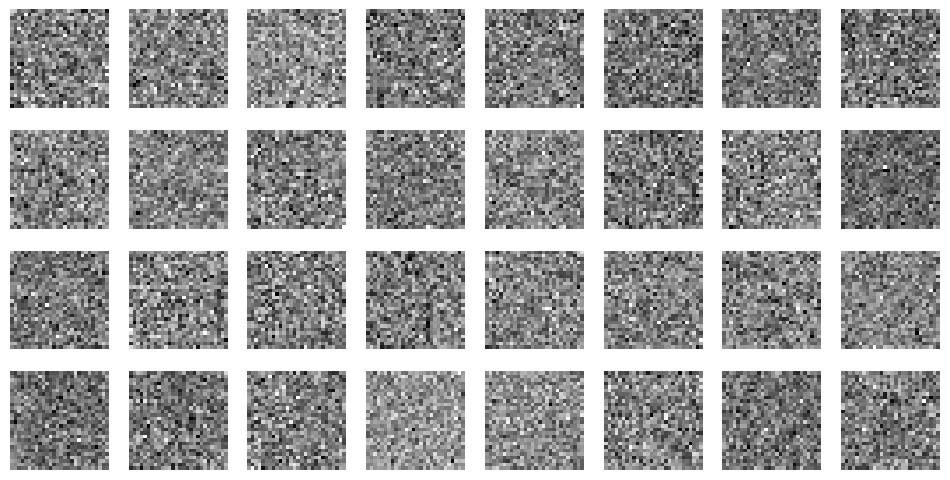

In [19]:
rando = torch.randn((32, 1, 28, 28))
print_gen_img(rando, 4, 8)

# Training

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yuvrajbalagoni (yuvrajbalagoni-indian-institute-of-technology-dhanbad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|          | 0/100 [00:00<?, ?it/s]

epoch : 0 g_loss : 2.38523658841451 d_loss : 0.14082846797679863


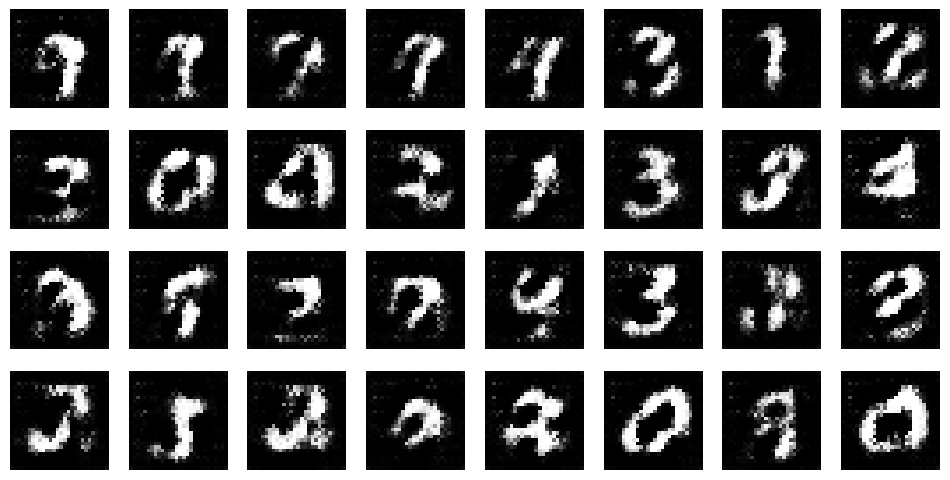

epoch : 1 g_loss : 1.0478398448308308 d_loss : 0.25322543490727745
epoch : 2 g_loss : 0.6624816123644511 d_loss : 0.2902339811642965
epoch : 3 g_loss : 0.4280751229604085 d_loss : 0.3196467966715495
epoch : 4 g_loss : 0.36239279227256777 d_loss : 0.33050765336354576
epoch : 5 g_loss : 0.33329463467597964 d_loss : 0.3338744743665059
epoch : 6 g_loss : 0.33608349294662476 d_loss : 0.32994564021428424
epoch : 7 g_loss : 0.3470346292813619 d_loss : 0.3260687046368917
epoch : 8 g_loss : 0.35147038720448814 d_loss : 0.3224335309346517
epoch : 9 g_loss : 0.3585391813278198 d_loss : 0.31853575391769406
epoch : 10 g_loss : 0.36370742441813153 d_loss : 0.31720930395126345


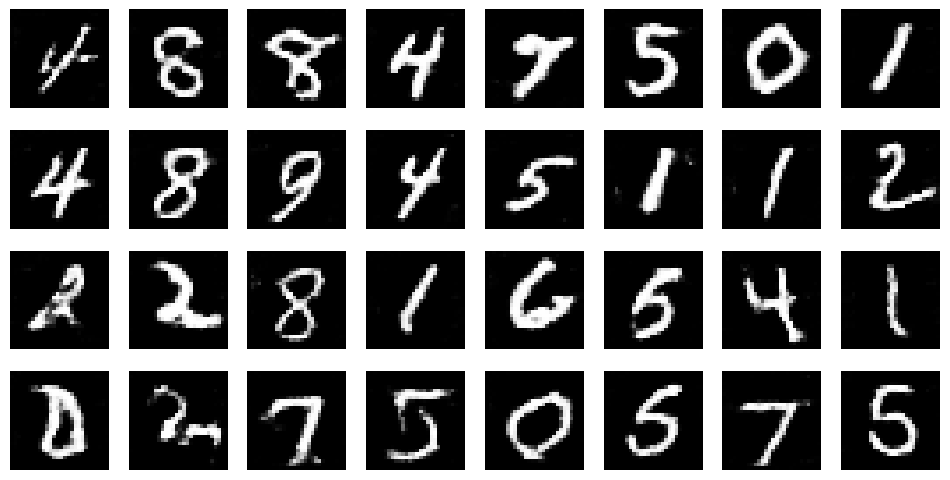

epoch : 11 g_loss : 0.3684827244758606 d_loss : 0.3141870962460836
epoch : 12 g_loss : 0.3735378596464793 d_loss : 0.3117689834276835
epoch : 13 g_loss : 0.3965367565155029 d_loss : 0.30381666797002155
epoch : 14 g_loss : 0.38841573481559755 d_loss : 0.3054175223350525
epoch : 15 g_loss : 0.4076847172578176 d_loss : 0.3013496170361837
epoch : 16 g_loss : 0.39683614959716795 d_loss : 0.3001638109207153
epoch : 17 g_loss : 0.40314879110654195 d_loss : 0.2965160541534424
epoch : 18 g_loss : 0.4173641246795654 d_loss : 0.29089489590326945
epoch : 19 g_loss : 0.4358024320602417 d_loss : 0.28644628502527875
epoch : 20 g_loss : 0.4381479731241862 d_loss : 0.2847299982706706


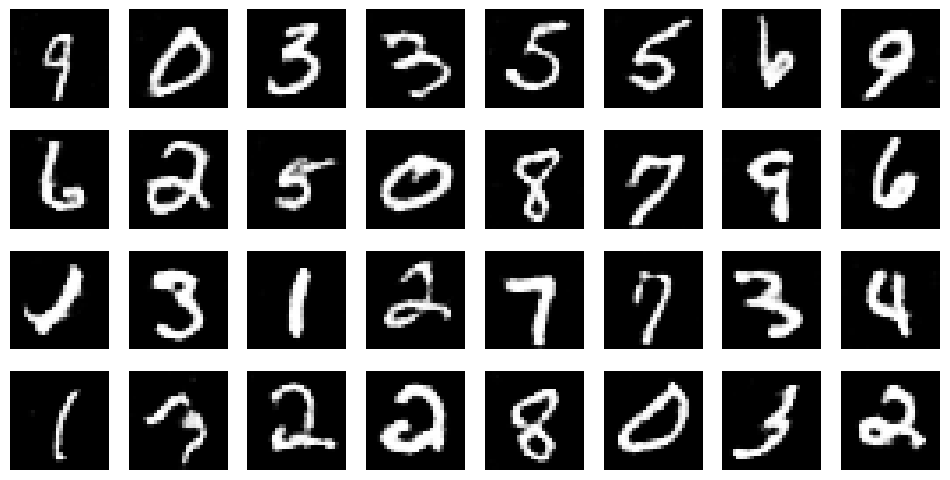

epoch : 21 g_loss : 0.4438430904070536 d_loss : 0.284419486840566
epoch : 22 g_loss : 0.4595030432383219 d_loss : 0.2771853270848592
epoch : 23 g_loss : 0.4618606868108114 d_loss : 0.2777510605812073
epoch : 24 g_loss : 0.4715895833174388 d_loss : 0.2710038876533508
epoch : 25 g_loss : 0.48175361636479697 d_loss : 0.26928391138712565
epoch : 26 g_loss : 0.48955536998113 d_loss : 0.26605725383758544
epoch : 27 g_loss : 0.5024324366251628 d_loss : 0.2625301592032115
epoch : 28 g_loss : 0.4962652150472005 d_loss : 0.26312003269195555
epoch : 29 g_loss : 0.5291205081303915 d_loss : 0.2554845434824626
epoch : 30 g_loss : 0.5261587097803752 d_loss : 0.25274269371032715


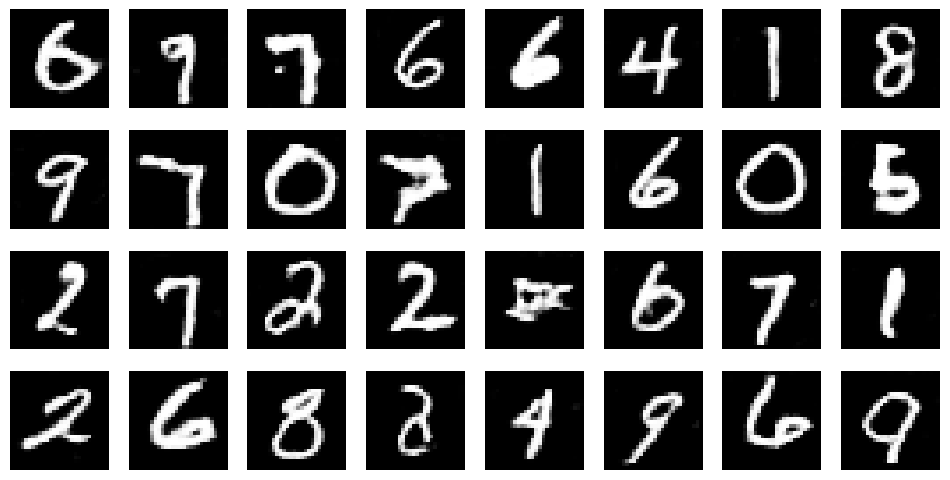

epoch : 31 g_loss : 0.5275781398773194 d_loss : 0.25694920762379964
epoch : 32 g_loss : 0.5251930966059367 d_loss : 0.2551194004217784
epoch : 33 g_loss : 0.5521558981895447 d_loss : 0.24331461288134257
epoch : 34 g_loss : 0.5542380333264669 d_loss : 0.2444540876865387
epoch : 35 g_loss : 0.5664274940172831 d_loss : 0.23960114267667135
epoch : 36 g_loss : 0.5631789552370707 d_loss : 0.2466696805636088
epoch : 37 g_loss : 0.5730474405288696 d_loss : 0.23992933500607808
epoch : 38 g_loss : 0.5838214253425598 d_loss : 0.24089533292452495
epoch : 39 g_loss : 0.5798820433298747 d_loss : 0.23879370516141254
epoch : 40 g_loss : 0.6129012778282166 d_loss : 0.22762800323168436


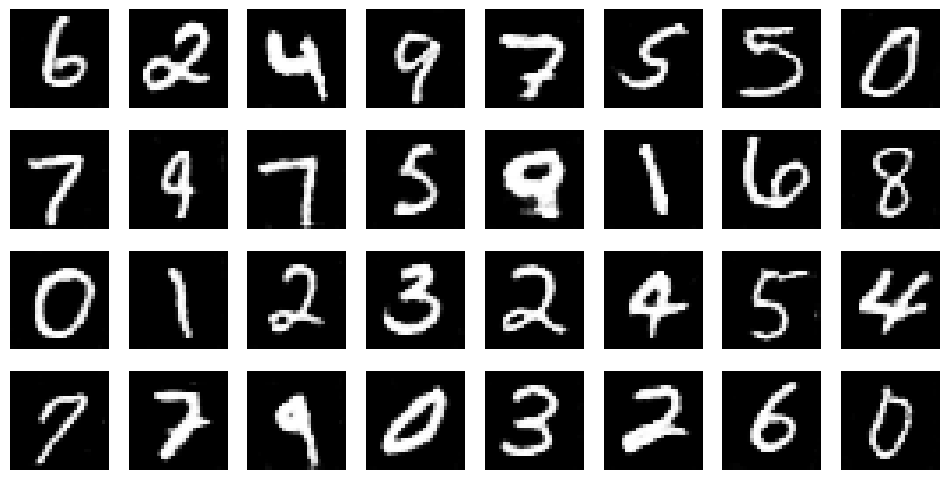

epoch : 41 g_loss : 0.6227903651237487 d_loss : 0.2272646712621053
epoch : 42 g_loss : 0.6188777393976848 d_loss : 0.22865615859031677
epoch : 43 g_loss : 0.6182706376075745 d_loss : 0.22807532250086465
epoch : 44 g_loss : 0.6460930732091268 d_loss : 0.22130395642916362
epoch : 45 g_loss : 0.6465197203159332 d_loss : 0.21937530395189922
epoch : 46 g_loss : 0.6508317977905274 d_loss : 0.21630101300875346
epoch : 47 g_loss : 0.6782931204160054 d_loss : 0.21157836078008016
epoch : 48 g_loss : 0.6807415893236796 d_loss : 0.2147672851085663
epoch : 49 g_loss : 0.6749371362050375 d_loss : 0.21345706362724304
epoch : 50 g_loss : 0.6864109354019166 d_loss : 0.20931969628334046


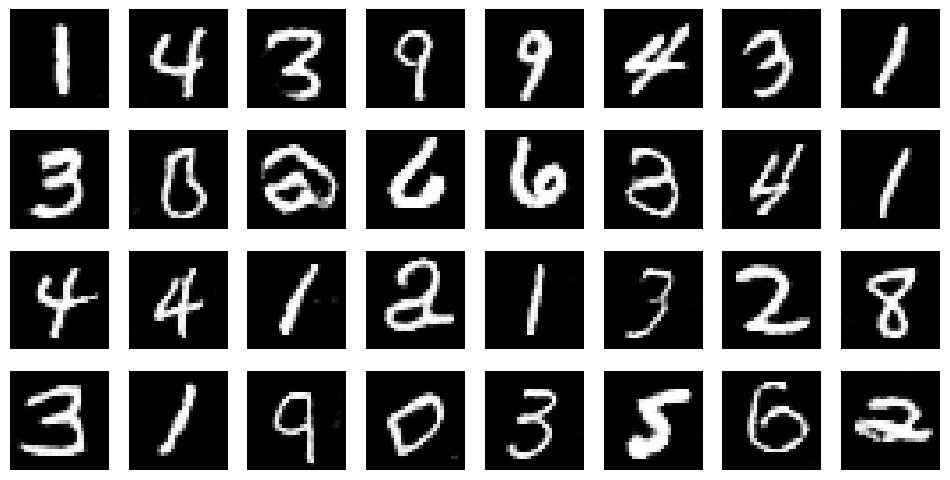

epoch : 51 g_loss : 0.7042386816501618 d_loss : 0.2055577401081721
epoch : 52 g_loss : 0.722184103902181 d_loss : 0.20246430656909942
epoch : 53 g_loss : 0.6993465307553609 d_loss : 0.20461032984256744
epoch : 54 g_loss : 0.7410626737594604 d_loss : 0.1954349632581075
epoch : 55 g_loss : 0.7382214338143667 d_loss : 0.19799887595176696
epoch : 56 g_loss : 0.7495415059089661 d_loss : 0.19625795669555665
epoch : 57 g_loss : 0.7351544308185577 d_loss : 0.19726366758346559
epoch : 58 g_loss : 0.7579431851387024 d_loss : 0.1947789657831192
epoch : 59 g_loss : 0.772287480131785 d_loss : 0.18704526761372883
epoch : 60 g_loss : 0.7892884267171224 d_loss : 0.18551490744749705


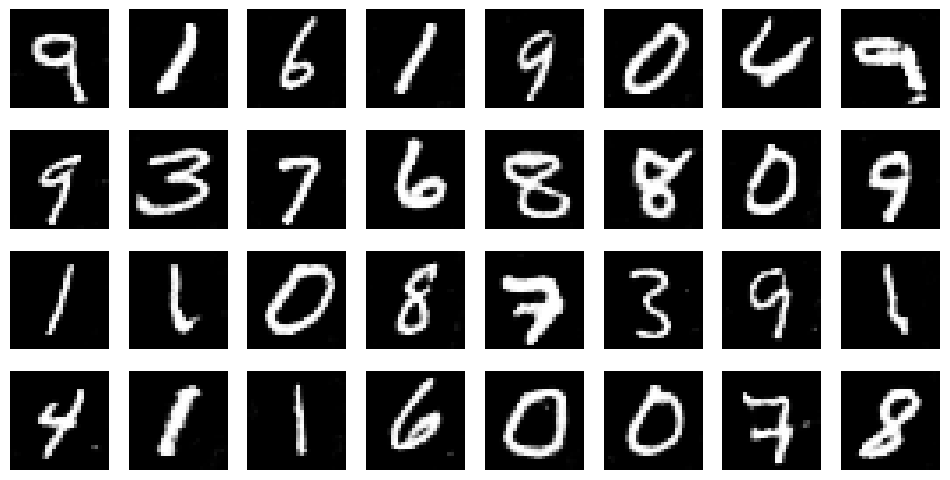

epoch : 61 g_loss : 0.7693957239468893 d_loss : 0.19157694207032522
epoch : 62 g_loss : 0.7806692356109619 d_loss : 0.19010607773462931
epoch : 63 g_loss : 0.7829974381923676 d_loss : 0.18759689819812775
epoch : 64 g_loss : 0.7893742272694906 d_loss : 0.18536817100048064
epoch : 65 g_loss : 0.7958571240107218 d_loss : 0.18729374465147655
epoch : 66 g_loss : 0.7926103450139363 d_loss : 0.1825210075457891
epoch : 67 g_loss : 0.8249429079055786 d_loss : 0.18146264016628266
epoch : 68 g_loss : 0.8197493936220804 d_loss : 0.1789938940445582
epoch : 69 g_loss : 0.8138546813646952 d_loss : 0.18102150543530782
epoch : 70 g_loss : 0.8217410364786784 d_loss : 0.1771997553507487


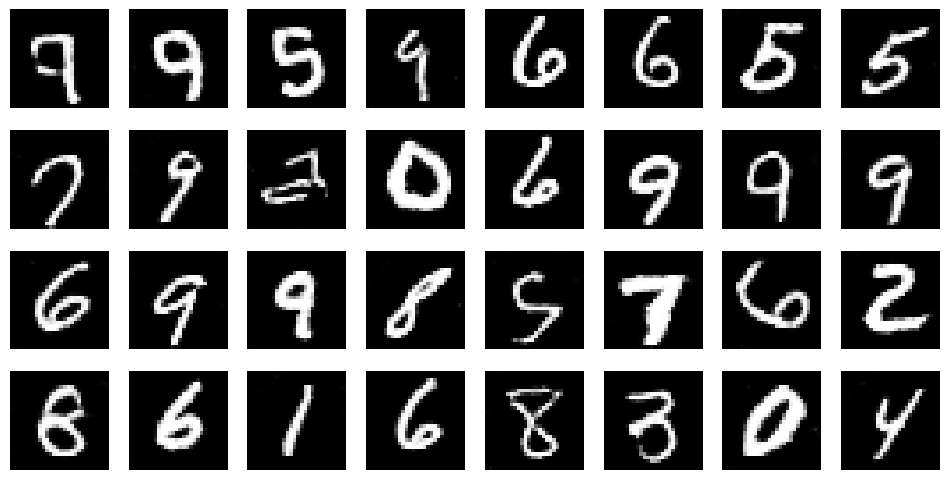

epoch : 71 g_loss : 0.826862346013387 d_loss : 0.18136396242777506
epoch : 72 g_loss : 0.873409842268626 d_loss : 0.16678441973527272
epoch : 73 g_loss : 0.864543928527832 d_loss : 0.17323536766767503
epoch : 74 g_loss : 0.8647351209958395 d_loss : 0.17128742672602335
epoch : 75 g_loss : 0.8675722656885783 d_loss : 0.17223789488871893
epoch : 76 g_loss : 0.8863002115885417 d_loss : 0.16071940032243728
epoch : 77 g_loss : 0.8838966190973918 d_loss : 0.16805228224595387
epoch : 78 g_loss : 0.8782335018793742 d_loss : 0.17051863901615144
epoch : 79 g_loss : 0.9143278465906779 d_loss : 0.1606763759414355
epoch : 80 g_loss : 0.8726158144950866 d_loss : 0.1762116904338201


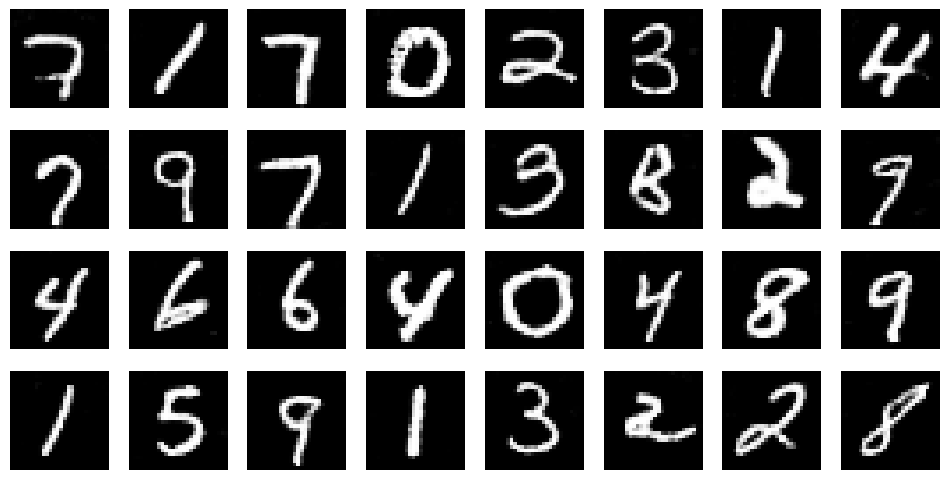

epoch : 81 g_loss : 0.8949771255175273 d_loss : 0.15837147930463155
epoch : 82 g_loss : 0.9419824652353923 d_loss : 0.15268658172686894
epoch : 83 g_loss : 0.9367346885999044 d_loss : 0.15837427583138147
epoch : 84 g_loss : 0.9306915104866028 d_loss : 0.16265873008171716
epoch : 85 g_loss : 0.9117394909222921 d_loss : 0.16553292509714762
epoch : 86 g_loss : 0.9164138075351715 d_loss : 0.1670531995455424
epoch : 87 g_loss : 0.920101387500763 d_loss : 0.16039780495166778
epoch : 88 g_loss : 0.9257251764615376 d_loss : 0.16164394927024842
epoch : 89 g_loss : 0.9355945919672648 d_loss : 0.15813849339882532
epoch : 90 g_loss : 0.9374570198376974 d_loss : 0.1625636875152588


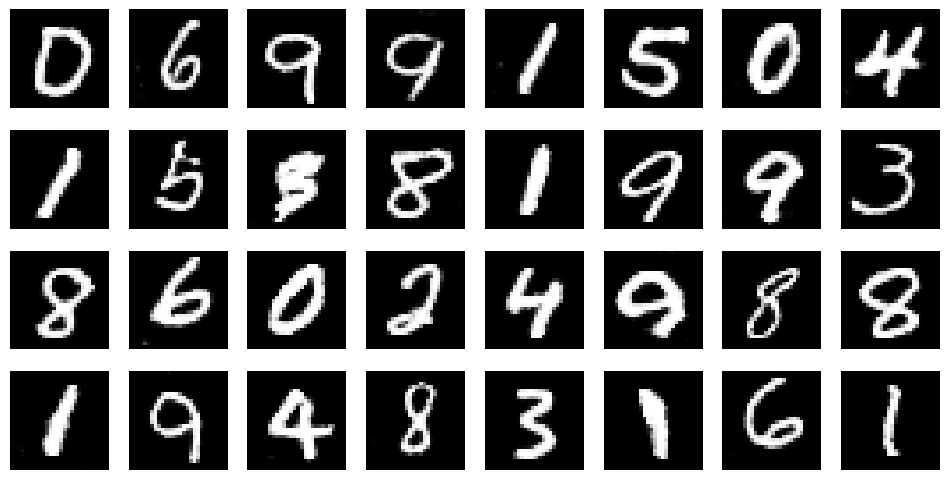

epoch : 91 g_loss : 0.9658884686470032 d_loss : 0.1512312075972557
epoch : 92 g_loss : 0.9310474684079488 d_loss : 0.16438352551460267
epoch : 93 g_loss : 0.9540822383244832 d_loss : 0.15052312800486883
epoch : 94 g_loss : 1.0010803651491802 d_loss : 0.14723617511987686
epoch : 95 g_loss : 1.020289381345113 d_loss : 0.1413402796347936
epoch : 96 g_loss : 1.006200144735972 d_loss : 0.15191493595838546
epoch : 97 g_loss : 1.0033729001363119 d_loss : 0.1477600882490476
epoch : 98 g_loss : 1.0142672496795655 d_loss : 0.14509545652469
epoch : 99 g_loss : 0.9822077330589294 d_loss : 0.15281279023885727


d_loss,▅▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁
g_loss,█▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇█
d_loss,0.15281
g_loss,0.98221


training Completed!


In [20]:
from tqdm.auto import tqdm
import torch.nn.functional as f
import onnxruntime as ort
import wandb
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = {
    "LR": 0.0001,
    "Epochs": 100,
    "Batch_Size": 32,
    "Num_Classes": 10
}

run = wandb.init(project="CGAN", config=config)

config = run.config

g_model = Generator(110, 1).to(device)
d_model = Discriminator(1, 28, 1, config.Num_Classes).to(device)

classifier_session = ort.InferenceSession("classifier16.onnx")

dataloader = DataLoader(mnist_dataset, batch_size=config.Batch_Size, shuffle=True)

loss = nn.BCELoss()
class_loss = nn.CrossEntropyLoss()

g_optim = torch.optim.Adam(g_model.parameters(), lr=config.LR, betas=(0.5, 0.999))
d_optim = torch.optim.Adam(d_model.parameters(), lr=config.LR, betas=(0.5, 0.999))

result = {
    "g_loss": [],
    "d_loss": []
}

for epoch in tqdm(range(config.Epochs)):
  # training
  g_loss_total = 0
  d_loss_total = 0
  for i, (x, y) in enumerate(dataloader):
    if i == 500:
      break
    current_batch_size = x.shape[0]

    # Input z generation
    x, y = x.to(device), y.to(device)
    z = create_noise(current_batch_size, 100, "normal").to(device)
    input_z = torch.concat((z, f.one_hot(y, num_classes=config.Num_Classes)), dim=1).view(-1, 110, 1, 1).to(device)

    # Generator prediction
    g_z = g_model(input_z)

    # classifying generated outputs age
    output_logits = classifier_session.run(None, {'input.1': g_z.detach().cpu().numpy()})
    output_logits = torch.tensor(output_logits[0]).to(device)

    ## Descriminator training
    d_optim.zero_grad()
    d_prob_real = d_model(x, y)
    d_prob_fake = d_model(g_z.detach(), y)

    d_real = torch.ones_like(d_prob_real)
    d_fake = torch.zeros_like(d_prob_fake)

    d_loss_real = loss(d_prob_real, d_real)
    d_loss_fake = loss(d_prob_fake, d_fake)
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optim.step()

    ## Generator training
    g_optim.zero_grad()
    d_prob_fake = d_model(g_z, y)

    # Adversarial loss for generator
    gen_loss = loss(d_prob_fake, torch.ones_like(d_prob_fake))

    # Classification loss for generator
    g_class_loss = class_loss(output_logits, y)

    # Total generator loss
    g_loss = gen_loss + g_class_loss
    g_loss.backward()
    g_optim.step()

    g_loss_total += g_loss.item()
    d_loss_total += d_loss.item()

  g_loss_total /= len(dataloader)
  d_loss_total /= len(dataloader)

  run.log(
      {
          "g_loss": g_loss_total,
          "d_loss": d_loss_total
      }
  )
  result["g_loss"].append(g_loss_total)
  result["d_loss"].append(d_loss_total)

  print(f"epoch : {epoch} g_loss : {g_loss_total} d_loss : {d_loss_total}")
  if epoch % 10 == 0:
    print_gen_img(g_z.detach().cpu().numpy(), 4, 8)

torch.onnx.export(
    g_model,
    torch.randn(1, 110, 1, 1).to(device),
    "generator_model.onnx",
    input_names=["input"],
    output_names=["output"],
)

run.log_artifact("generator_model.onnx", type="model")
run.finish()
print(f"training Completed!")

# Inference Pipeline

In [53]:
z = create_noise(1, 100, "normal")
y = torch.tensor([7])
y_one_hot = f.one_hot(y, num_classes=10)
input_z = torch.concat((z, y_one_hot), dim=1).view(1, 110, 1, 1)

gen_session = ort.InferenceSession("generator_model.onnx")
output = gen_session.run(None, {"input": input_z.numpy()})

In [54]:
output[0][0].shape

(1, 28, 28)

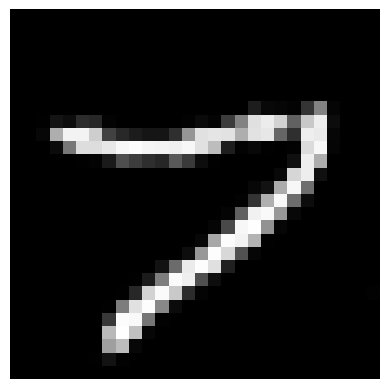

In [55]:
import matplotlib.pyplot as plt

plt.imshow(output[0][0].reshape(28, 28), cmap="gray")
plt.axis(False)
plt.show()